In [1]:
# ============================================================
# BOX 1/3 — Reading data (build X with x-threshold crop)
# ============================================================
from __future__ import annotations

from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# Optional (cluster): safe to leave in; script will still run without MPI in serial
try:
    from mpi4py import MPI
    comm = MPI.COMM_WORLD
    rank = comm.rank
except Exception:
    comm = None
    rank = 0

# ============================================================
# USER SETTINGS
# ============================================================
TIME_STEP_START = 200
TIME_STEP_END   = 270

PHI      = 0.40
LAT_SIZE = "025"
POST     = True

BASE_DIR  = Path("../data/isocontours")
VAR_NAME  = "T"
SORT_COLS = ["x", "y"]
COORD_TOL = 0.0

# Crop threshold (keep only x > threshold)
X_THESHOLD = 300

# ============================================================
# File helpers
# ============================================================
def field_csv_path(base_dir: Path, phi: float, lat_size: str, time_step: int, post: bool) -> Path:
    case = Case(
        base_dir=base_dir,
        phi=phi,
        lat_size=lat_size,
        time_step=time_step,
        post=post,
    )
    return field_path(case)

def read_field_sorted(path: Path, var_name: str, sort_cols: list[str]) -> tuple[np.ndarray, np.ndarray]:
    if not path.exists():
        raise FileNotFoundError(f"Missing file:\n  {path}")

    df = pd.read_csv(path)
    missing = [c for c in (sort_cols + [var_name]) if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=sort_cols + [var_name])
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

    coords = df[sort_cols].to_numpy(dtype=np.float64)
    values = df[var_name].to_numpy(dtype=np.float64)
    return coords, values

# ============================================================
# Build snapshot matrix X (cropped consistently by x-threshold)
# ============================================================
times = list(range(TIME_STEP_START, TIME_STEP_END + 1))

ref_path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, times[0], POST)
coords_ref_full, snap0_full = read_field_sorted(ref_path, VAR_NAME, SORT_COLS)

mask_x = coords_ref_full[:, 0] > float(X_THESHOLD)
coords_ref = coords_ref_full[mask_x]
snap0 = snap0_full[mask_x]

n_points_full = coords_ref_full.shape[0]
n_points = coords_ref.shape[0]
n_snaps = len(times)

if rank == 0:
    print(f"Reference timestep: {times[0]}")
    print(f"n_points_full={n_points_full}, n_points_cropped={n_points}, n_snapshots={n_snaps}")
    print(f"X_THESHOLD={X_THESHOLD} -> keeping x > {X_THESHOLD}")
    print(f"Reading: {ref_path}")

snapshots = [snap0]

for t in times[1:]:
    path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t, POST)
    coords_t_full, snap_t_full = read_field_sorted(path, VAR_NAME, SORT_COLS)

    if coords_t_full.shape[0] != n_points_full:
        raise ValueError(
            f"Full point count changed at timestep {t}: {coords_t_full.shape[0]} vs {n_points_full}."
        )

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t_full, coords_ref_full)
    else:
        same = np.allclose(coords_t_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            f"Full coordinates do not match reference at timestep {t}. "
            f"Set COORD_TOL>0 or interpolate to a common grid."
        )

    snapshots.append(snap_t_full[mask_x])

X = np.stack(snapshots, axis=1)  # (n_points_cropped, n_snaps)
if rank == 0:
    print("X shape (cropped):", X.shape)

# If running with MPI, train only on rank 0
if rank != 0:
    raise SystemExit(0)


Reference timestep: 200
n_points_full=839680, n_points_cropped=255744, n_snapshots=71
X_THESHOLD=300 -> keeping x > 300
Reading: ..\isocontours\phi0.40\h400x025_ref\extracted_field_post_200.csv
X shape (cropped): (255744, 71)


In [8]:
from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
# ============================================================
# BOX 2/3 — Training (AE + Latent ODE) + one-step forecast + save CSV
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim

try:
    from torchdiffeq import odeint
except ImportError as e:
    raise ImportError("Please install torchdiffeq: pip install torchdiffeq") from e

# ============================================================
# Latent ODE settings
# ============================================================
DT = 1.0

USE_PCA = True
PCA_DIM = 64

Z_DIM = 16
AE_HIDDEN = (128, 128)
ODE_HIDDEN = (64, 64)

AE_PRETRAIN_EPOCHS = 3000
ODE_TRAIN_EPOCHS   = 1500
FINE_TUNE_EPOCHS   = 300

LR_AE   = 5e-4
LR_ODE  = 3e-3
LR_FINE = 2e-4

DEVICE = "cuda"

if DEVICE == "cuda" and not torch.cuda.is_available():
    DEVICE = "cpu"
device = torch.device(DEVICE)
print("Using device:", device)

# Prepare training sequence: (T, x_dim_fullcropped)
X_seq = X.T.astype(np.float32)  # (T, n_points_cropped)

# Normalize per spatial DOF over time
X_mean = X_seq.mean(axis=0, keepdims=True)
X_std  = X_seq.std(axis=0, keepdims=True) + 1e-6
Xn_seq = (X_seq - X_mean) / X_std

# Optional PCA
if USE_PCA:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=min(PCA_DIM, n_snaps, n_points), svd_solver="randomized", random_state=0)
    Y = pca.fit_transform(Xn_seq)  # (T, pca_dim)
    x_dim_model = Y.shape[1]
    if x_dim_model < 2:
        raise ValueError("PCA_DIM too small or not enough snapshots; increase PCA_DIM or snapshots.")
    print(f"PCA enabled: {n_points} -> {x_dim_model} dims (explained var ~ {pca.explained_variance_ratio_.sum():.3f})")
else:
    pca = None
    Y = Xn_seq
    x_dim_model = Y.shape[1]
    print("PCA disabled: model input dim =", x_dim_model)

Y_t = torch.as_tensor(Y, dtype=torch.float32, device=device)  # (T, x_dim_model)

T_len = Y_t.shape[0]
t_vec = torch.arange(T_len, device=device, dtype=torch.float32) * float(DT)
t_vec_ext = torch.arange(T_len + 1, device=device, dtype=torch.float32) * float(DT)

class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden=(128, 128), act=nn.SiLU):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), act()]
            d = h
        layers += [nn.Linear(d, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class AutoEncoder(nn.Module):
    def __init__(self, x_dim: int, z_dim: int, hidden=(128, 128)):
        super().__init__()
        self.enc = MLP(x_dim, z_dim, hidden=hidden)
        self.dec = MLP(z_dim, x_dim, hidden=hidden)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.enc(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.dec(z)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decode(self.encode(x))

class ODEFunc(nn.Module):
    def __init__(self, z_dim: int, hidden=(64, 64)):
        super().__init__()
        self.f = MLP(z_dim, z_dim, hidden=hidden)

    def forward(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        return self.f(z)

class LatentODE(nn.Module):
    def __init__(self, ae: AutoEncoder, odefunc: ODEFunc, solver="dopri5"):
        super().__init__()
        self.ae = ae
        self.odefunc = odefunc
        self.solver = solver

    def rollout_from_x0(self, x0: torch.Tensor, t: torch.Tensor, rtol=1e-4, atol=1e-5) -> torch.Tensor:
        z0 = self.ae.encode(x0)  # (1, z_dim)
        zt = odeint(self.odefunc, z0, t, method=self.solver, rtol=rtol, atol=atol)  # (T,1,z_dim)
        xt = self.ae.decode(zt)  # (T,1,x_dim)
        return xt

ae = AutoEncoder(x_dim_model, Z_DIM, hidden=AE_HIDDEN).to(device)
odefunc = ODEFunc(Z_DIM, hidden=ODE_HIDDEN).to(device)
model = LatentODE(ae, odefunc, solver="dopri5").to(device)

mse = nn.MSELoss()

def pretrain_ae(ae: AutoEncoder, Y: torch.Tensor, epochs: int, lr: float, batch: int = 32) -> None:
    ae.train()
    opt = optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-6)
    n = Y.shape[0]
    for ep in range(1, epochs + 1):
        idx = torch.randperm(n, device=Y.device)
        losses = []
        for i in range(0, n, batch):
            b = idx[i:i + batch]
            yb = Y[b]
            yhat = ae(yb)
            loss = mse(yhat, yb)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()
            losses.append(loss.item())
        if ep % 50 == 0 or ep == 1:
            print(f"[AE] epoch {ep:4d}/{epochs}  loss={float(np.mean(losses)):.4e}")

def train_latent_ode(
    model: LatentODE,
    Y: torch.Tensor,
    t: torch.Tensor,
    epochs: int,
    lr: float,
    freeze_ae: bool = True,
    rtol: float = 1e-4,
    atol: float = 1e-5,
) -> None:
    if freeze_ae:
        for p in model.ae.parameters():
            p.requires_grad = False
        model.ae.eval()
    else:
        for p in model.ae.parameters():
            p.requires_grad = True
        model.ae.train()

    for p in model.odefunc.parameters():
        p.requires_grad = True
    model.odefunc.train()

    params = [p for p in model.parameters() if p.requires_grad]
    opt = optim.Adam(params, lr=lr, weight_decay=1e-7)

    x0 = Y[0:1]  # (1, x_dim)

    for ep in range(1, epochs + 1):
        xt_hat = model.rollout_from_x0(x0, t, rtol=rtol, atol=atol)[:, 0, :]  # (T,x_dim)
        loss = mse(xt_hat, Y)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, 1.0)
        opt.step()

        if ep % 100 == 0 or ep == 1:
            print(f"[ODE] epoch {ep:4d}/{epochs}  rollout_loss={loss.item():.4e}")

# 1) AE pretrain
pretrain_ae(ae, Y_t, epochs=AE_PRETRAIN_EPOCHS, lr=LR_AE, batch=min(32, T_len))

# 2) ODE train (AE frozen)
train_latent_ode(model, Y_t, t_vec, epochs=ODE_TRAIN_EPOCHS, lr=LR_ODE, freeze_ae=True)

# 3) Fine-tune (unfreeze AE)
train_latent_ode(model, Y_t, t_vec, epochs=FINE_TUNE_EPOCHS, lr=LR_FINE, freeze_ae=False)

# Forecast next step (T -> T+1)
model.ae.eval()
model.odefunc.eval()

with torch.no_grad():
    x0 = Y_t[0:1]
    xt_hat_ext = model.rollout_from_x0(x0, t_vec_ext, rtol=1e-4, atol=1e-5)  # (T+1,1,x_dim)
    y_next_pred = xt_hat_ext[-1, 0, :].cpu().numpy()  # (x_dim_model,)

# Back to original cropped field
if USE_PCA:
    x_next_pred_norm = pca.inverse_transform(y_next_pred[None, :])[0]
else:
    x_next_pred_norm = y_next_pred

x_next_pred = (x_next_pred_norm * X_std[0] + X_mean[0]).astype(np.float64)  # (n_points_cropped,)
t_next = TIME_STEP_END + 1

# Save prediction
out_dir = field_path(Case(base_dir=BASE_DIR, phi=PHI, lat_size=LAT_SIZE, time_step=0, post=POST)).parent
out_dir.mkdir(parents=True, exist_ok=True)

out = pd.DataFrame(coords_ref, columns=SORT_COLS)
out[f"{VAR_NAME}_pred"] = x_next_pred
out_path = out_dir / f"latentODE_pred_{VAR_NAME}_{t_next}_xgt{int(X_THESHOLD)}.csv"
out.to_csv(out_path, index=False)
print("Wrote:", out_path)


Using device: cuda
PCA enabled: 255744 -> 64 dims (explained var ~ 0.999)
[AE] epoch    1/3000  loss=2.3511e+03
[AE] epoch   50/3000  loss=6.9410e+02
[AE] epoch  100/3000  loss=3.6595e+02
[AE] epoch  150/3000  loss=2.5878e+02
[AE] epoch  200/3000  loss=1.8705e+02
[AE] epoch  250/3000  loss=1.3979e+02
[AE] epoch  300/3000  loss=9.5019e+01
[AE] epoch  350/3000  loss=7.8770e+01
[AE] epoch  400/3000  loss=6.4366e+01
[AE] epoch  450/3000  loss=4.7559e+01
[AE] epoch  500/3000  loss=4.0062e+01
[AE] epoch  550/3000  loss=3.0877e+01
[AE] epoch  600/3000  loss=2.7558e+01
[AE] epoch  650/3000  loss=1.7672e+01
[AE] epoch  700/3000  loss=1.8739e+01
[AE] epoch  750/3000  loss=1.2174e+01
[AE] epoch  800/3000  loss=1.0591e+01
[AE] epoch  850/3000  loss=1.1162e+01
[AE] epoch  900/3000  loss=8.1803e+00
[AE] epoch  950/3000  loss=4.6522e+00
[AE] epoch 1000/3000  loss=6.9481e+00
[AE] epoch 1050/3000  loss=3.9351e+00
[AE] epoch 1100/3000  loss=3.6876e+00
[AE] epoch 1150/3000  loss=2.4692e+00
[AE] epoch 120

[LatentODE] Next-step RMSE: 4.944445e-01
[LatentODE] Next-step relative L2: 1.286538e-01


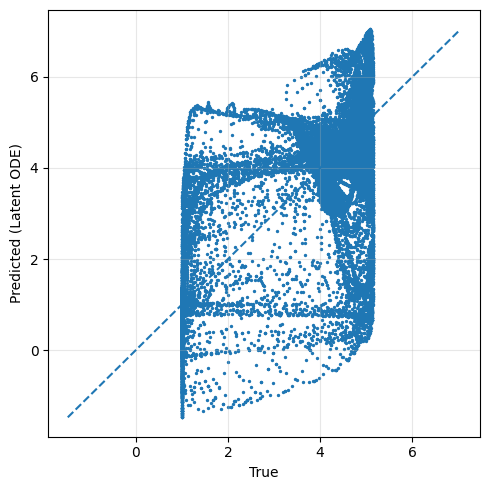

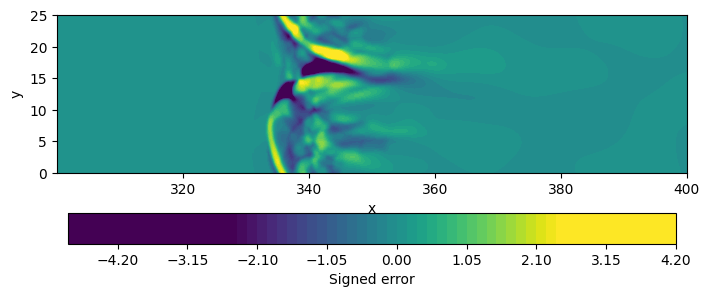

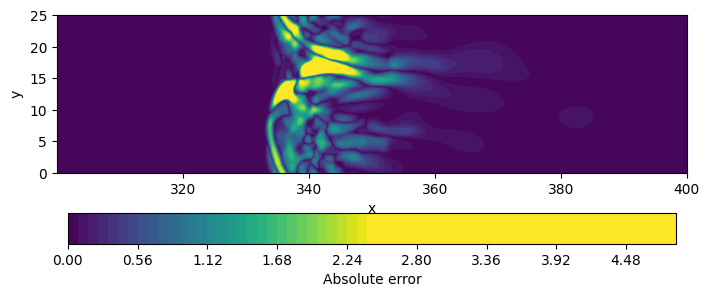

In [9]:
# ============================================================
# BOX 3/3 — Plotting (comparison + error maps + scatter)
# ============================================================
path_true = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t_next, POST)

if path_true.exists():
    coords_true_full, snap_true_full = read_field_sorted(path_true, VAR_NAME, SORT_COLS)

    # FULL coordinate check first
    if coords_true_full.shape[0] != coords_ref_full.shape[0]:
        raise ValueError("True next-step full point count changed; cannot compare directly.")

    if COORD_TOL == 0.0:
        same_full = np.array_equal(coords_true_full, coords_ref_full)
    else:
        same_full = np.allclose(coords_true_full, coords_ref_full, atol=COORD_TOL, rtol=0.0)

    if not same_full:
        raise ValueError("True next-step full coordinates changed; cannot compare directly.")

    snap_true = snap_true_full[mask_x].astype(np.float64)

    err = x_next_pred - snap_true
    abs_err = np.abs(err)

    rmse = float(np.sqrt(np.mean(err ** 2)))
    rel_l2 = float(np.linalg.norm(err) / (np.linalg.norm(snap_true) + 1e-30))
    print(f"[LatentODE] Next-step RMSE: {rmse:.6e}")
    print(f"[LatentODE] Next-step relative L2: {rel_l2:.6e}")

    # Scatter true vs pred
    plt.figure(figsize=(5, 5))
    plt.scatter(snap_true, x_next_pred, s=2)
    lo = float(min(snap_true.min(), x_next_pred.min()))
    hi = float(max(snap_true.max(), x_next_pred.max()))
    plt.plot([lo, hi], [lo, hi], linestyle="--")
    plt.xlabel("True")
    plt.ylabel("Predicted (Latent ODE)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Triangulation plots (cropped coords)
    x_xy = coords_ref[:, 0].astype(float)
    y_xy = coords_ref[:, 1].astype(float)
    tri = mtri.Triangulation(x_xy, y_xy)

    try:
        analyzer = mtri.TriAnalyzer(tri)
        tri.set_mask(analyzer.get_flat_tri_mask(min_circle_ratio=0.02))
    except Exception:
        pass

    vmax_signed = np.percentile(np.abs(err), 99.0) + 1e-30
    vmax_abs = np.percentile(abs_err, 99.0) + 1e-30

    # Signed error map
    fig = plt.figure(figsize=(7.2, 5.8))
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, err, levels=60, vmin=-vmax_signed, vmax=vmax_signed)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label("Signed error")
    plt.tight_layout()
    plt.show()

    # Absolute error map
    fig = plt.figure(figsize=(7.2, 5.8))
    ax = fig.add_subplot(111)
    cf = ax.tricontourf(tri, abs_err, levels=60, vmin=0.0, vmax=vmax_abs)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    cbar = fig.colorbar(cf, ax=ax, orientation="horizontal", pad=0.08, fraction=0.06)
    cbar.set_label("Absolute error")
    plt.tight_layout()
    plt.show()

else:
    print("True next-step file does not exist; only the forecast was saved.")
